In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
file_path = "Bank-Customer-Attrition-Insights-Data.csv"
df = pd.read_csv(file_path)

In [45]:
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',
                  'NumOfProducts', 'EstimatedSalary', 'Point Earned', 'Satisfaction Score']
print("Class Distribution:\n", df['Exited'].value_counts(normalize=True))

Class Distribution:
 Exited
0    0.7962
1    0.2038
Name: proportion, dtype: float64


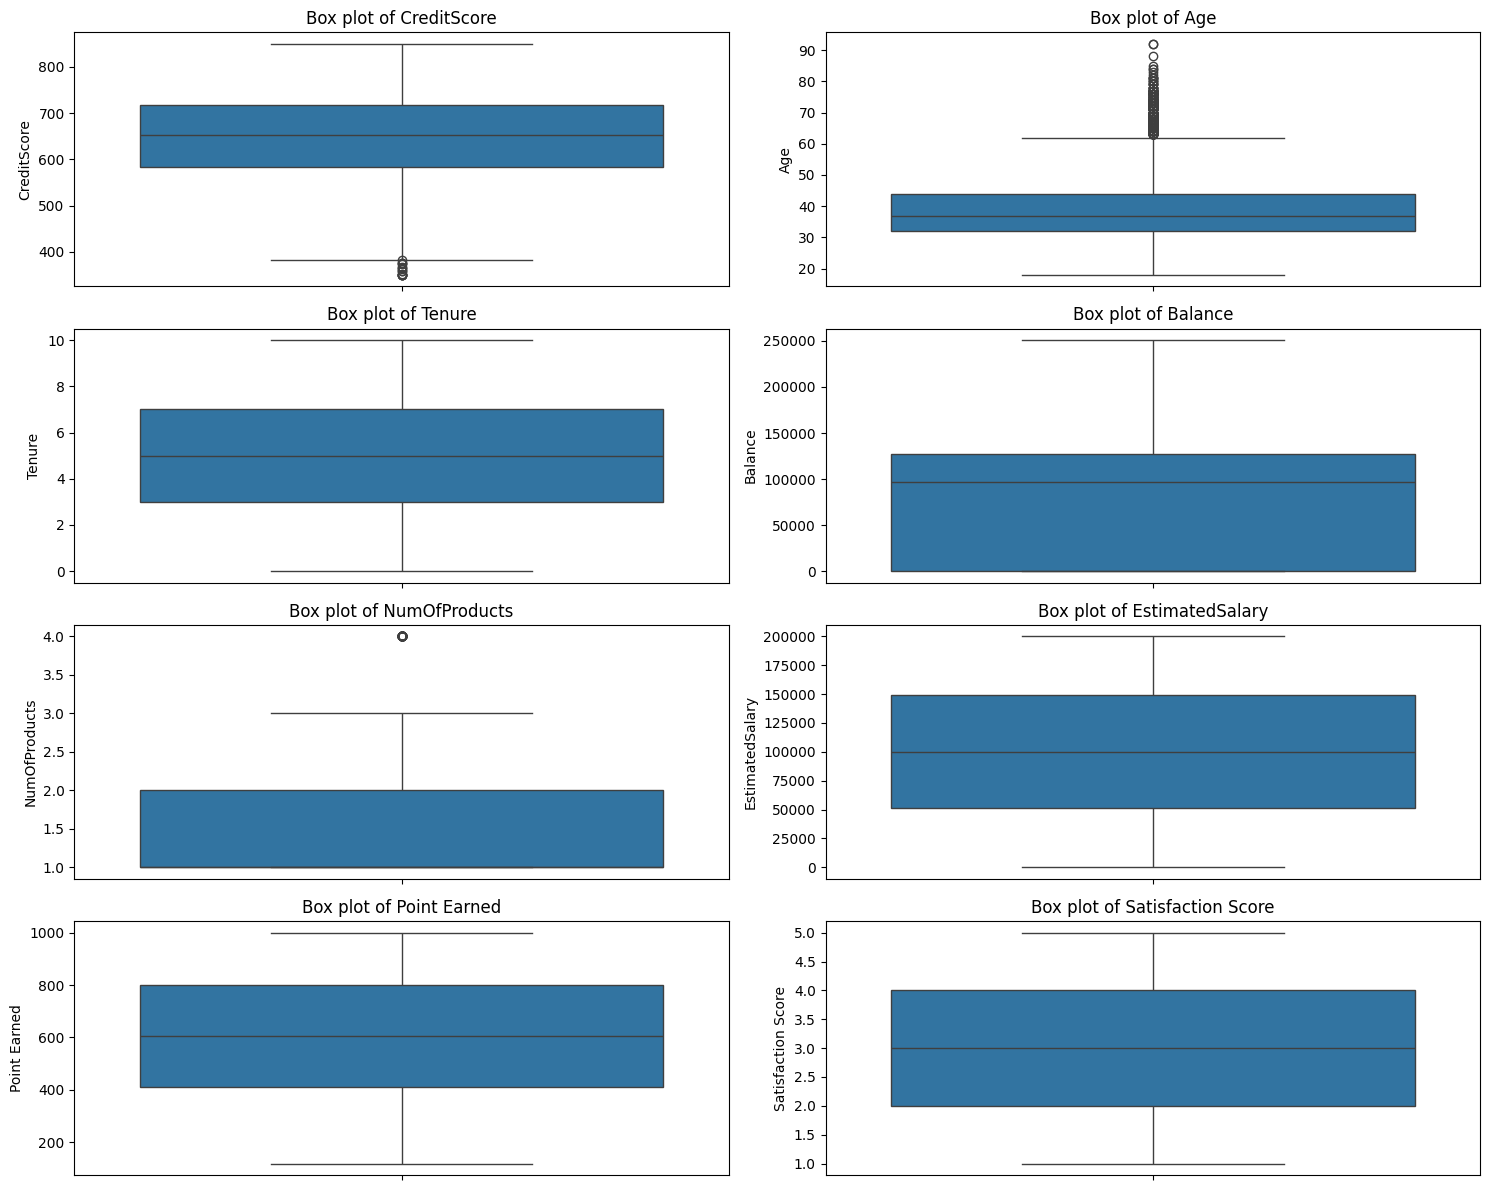

In [46]:
# Plot box plots to visualize outliers
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(4, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')

plt.tight_layout()
plt.show()

In [47]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

In [48]:
# Function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    df_clean = df[(np.abs(stats.zscore(df[columns])) < threshold).all(axis=1)]
    return df_clean

# Remove outliers using both methods
df_clean_iqr = remove_outliers_iqr(df, numerical_cols)
df_clean_zscore = remove_outliers_zscore(df, numerical_cols)

In [49]:
print(f"Original data: {df.shape[0]} rows")
print(f"After IQR removal: {df_clean_iqr.shape[0]} rows")
print(f"After Z-score removal: {df_clean_zscore.shape[0]} rows")

Original data: 10000 rows
After IQR removal: 9568 rows
After Z-score removal: 9799 rows


In [50]:
# Prepare features and target variable
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])
X_iqr = df_clean_iqr.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])
X_zscore = df_clean_zscore.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])

In [51]:
# Convert categorical variables into numeric format
X = pd.get_dummies(X, drop_first=True)
X_iqr = pd.get_dummies(X_iqr, drop_first=True)
X_zscore = pd.get_dummies(X_zscore, drop_first=True)

y = df['Exited']
y_iqr = df_clean_iqr['Exited']
y_zscore = df_clean_zscore['Exited']

In [52]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = train_test_split(X_iqr, y_iqr, test_size=0.2, random_state=42)
X_train_zscore, X_test_zscore, y_train_zscore, y_test_zscore = train_test_split(X_zscore, y_zscore, test_size=0.2, random_state=42)

In [53]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_iqr = scaler.fit_transform(X_train_iqr)
X_test_iqr = scaler.transform(X_test_iqr)
X_train_zscore = scaler.fit_transform(X_train_zscore)
X_test_zscore = scaler.transform(X_test_zscore)

In [54]:
# Hyperparameter tuning for SVM
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_svm = GridSearchCV(SVC(), param_grid_svm, cv=5)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_

In [ ]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

In [56]:
# Train and evaluate SVM
svm_pred = best_svm.predict(X_test)
svm_pred_iqr = best_svm.predict(X_test_iqr)
svm_pred_zscore = best_svm.predict(X_test_zscore)

In [57]:
# Train and evaluate Random Forest
rf_pred = best_rf.predict(X_test)
rf_pred_iqr = best_rf.predict(X_test_iqr)
rf_pred_zscore = best_rf.predict(X_test_zscore)

In [58]:
print("\n=== SVM Results ===")
print(f"Accuracy (original): {accuracy_score(y_test, svm_pred):.4f}")
print(f"Accuracy (IQR): {accuracy_score(y_test_iqr, svm_pred_iqr):.4f}")
print(f"Accuracy (Z-score): {accuracy_score(y_test_zscore, svm_pred_zscore):.4f}")
print("\nF1-score (original):\n", classification_report(y_test, svm_pred))
print("\nF1-score (IQR):\n", classification_report(y_test_iqr, svm_pred_iqr))
print("\nF1-score (Z-score):\n", classification_report(y_test_zscore, svm_pred_zscore))


=== SVM Results ===
Accuracy (original): 0.9990
Accuracy (IQR): 0.9990
Accuracy (Z-score): 0.9985

F1-score (original):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       1.00      1.00      1.00       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


F1-score (IQR):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1523
           1       1.00      1.00      1.00       391

    accuracy                           1.00      1914
   macro avg       1.00      1.00      1.00      1914
weighted avg       1.00      1.00      1.00      1914


F1-score (Z-score):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1550
           1       1.00      1.00      1.00       410

    accuracy        

In [59]:
print("\n=== Random Forest Results ===")
print(f"Accuracy (original): {accuracy_score(y_test, rf_pred):.4f}")
print(f"Accuracy (IQR): {accuracy_score(y_test_iqr, rf_pred_iqr):.4f}")
print(f"Accuracy (Z-score): {accuracy_score(y_test_zscore, rf_pred_zscore):.4f}")
print("\nF1-score (original):\n", classification_report(y_test, rf_pred))
print("\nF1-score (IQR):\n", classification_report(y_test_iqr, rf_pred_iqr))
print("\nF1-score (Z-score):\n", classification_report(y_test_zscore, rf_pred_zscore))


=== Random Forest Results ===
Accuracy (original): 0.9990
Accuracy (IQR): 0.9990
Accuracy (Z-score): 0.9995

F1-score (original):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       1.00      1.00      1.00       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


F1-score (IQR):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1523
           1       1.00      1.00      1.00       391

    accuracy                           1.00      1914
   macro avg       1.00      1.00      1.00      1914
weighted avg       1.00      1.00      1.00      1914


F1-score (Z-score):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1550
           1       1.00      1.00      1.00       410

    accura